# The Multi-Layer Perceptron
Any neural network is simply a series of perceptrons feeding into one another. The perceptrons are arranged in layers with the outputs of a previous layer being the inputs into the next layer.

With this in mind it seems that we did much of the heavy lifting in our [first notebook](./01. The Perceptron.ipynb) concerning the percepton - the single neuron emulating unit that is the building block of a neural network.

In this workbook we will consider the simplest case of a fully-connected network. That is a network where each node (percepton) in a given layer is connected to every node in the subsequent layer. This means that the output of a perceptron in the first layer will therefore be an input into each perceptron in the next layer.

![Neural Network Diagram](./img/neural-network.png "A Fully Connected Neural Network")

## Expressiveness of Neural Networks

## Training a Neural Network vs Training a Perceptron
Similarly to the case of the vanilla perceptron we considered before, the values passed as inputs to each layer (and therefore each perceptron in that layer) will have weights associated with them. These weights will be the variables which we will vary as part of the training process with the ultimate goal of loss minimisation.

In contrast to a single perceptron, a multi-layer perceptron must be trained in a more complex way since the weights in the first layer only have an indirect impact on the output albeit through many channels in a fully connected network. This indirect influence is difficult to trace through should the step activation function be kept. The discontinuous function is not differentiable and hence we are unable to perform what's known as backpropagation to calculate the impact of early layer weights on the ultimate output. Backpropagation is the algorithmic way of training a neural network. Errors in the output are traced back through the layers of the network and the weights are updated in turn in order to reduce the error. We will consider this process in detail later. 

In order to undertake backpropagation the error, or more specifically the model prediction, needs to be differentiable with respect to the weights. In order to achieve this, a smooth (differentiable) activation function is used in place of the perceptron step function.

These functions are known as activation functions because they play the role of the activation threshold in the perceptron or the neuron being emulated. Popular choices are the sigmoid function, tanh and the Rectified Linear Unit function (ReLU).

We will discuss the mathematics of backpropagation in detail [later](#backpropagation).


## Activation Functions
Activation functions determine how a perceptron produces its output. Unlike neurons, perceptrons are not limited to binary output and hence may produce any real number as their output. The choice of activation function can therefore shape this output by shaping the relationship between inputs and the output beyond the linear way in which weights enter the equation. This relationship change can be made for computational ease, to match the relationship we are trying to estimate or to aid in training the model.

In the case of the neurons in our brains that the perceptrons aim to emulate, activation functions play the role of the activation threshold. In the brain the threshold is placed on a concentration gradient across a membrane which much reach a certain strength before an activation potential will be passed along the neuron. In our case, working in the mathematics of real numbers we need not limit ourselves to binary output. We may consider any output on the real domain. This can be considered the number of action potentials per second should one wish to maintain the biological parallels.

### The Sigmoid Function
A binary classifier may aim to place a probability on the given input belonging to a given class. This will mean that the outputs must, by way of being probabilities, fall in the unit interval ($o \in [0,1]$). The sigmoid function will always produce outputs that are between 0 and 1 and can therefore be considered valid probabilities. The functional form of the sigmoid function is given below.

$$\sigma(x)=\frac{1}{1+e^{-x}}$$

<small><center><span style="color:gray">*The Sigmoid Function*</span></center></small>


Note that this function is strictly increasing in $x$ and varies from $0$ when $x$ is $-\infty$ and 1 when $x$ is $\infty$. It is smooth, defined for all real numbers and differentiable.

Infact the differential takes a rather nice form which is one reason for the function's popularity. This will help us when training the model later on.


$$\sigma(x)=\frac{1}{1+e^{-x}}$$
<small><center><span style="color:gray">*The Sigmoid Function*</span></center></small>

Let's plot this function so that we can see what we're dealing with.

First we'll import our mathematical toolkit `numpy` and the plotting tools `matplotlib` and `seaborn`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Let's define our sigmoid function.

Note that we decorate it with `numpy`'s `vectorize` function so that the function can be called on lists and arrays without further modification.

In [2]:
@np.vectorize
def sigmoid(x):
    return 1/(1+np.exp(-x))

Finally let us generate some points and create a plot.

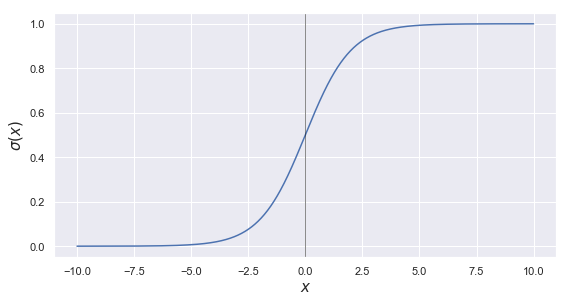

In [3]:
x = np.linspace(-10, 10, 1000)
y = sigmoid(x)
plt.plot(x,y, figure=plt.figure(figsize=(9,4.5)))
plt.axvline(0, color='k', lw=0.5)
plt.xlabel('$x$', size=15)
plt.ylabel('$\sigma(x)$', size=15);

Let us find the differential by applying the quotient rule. 

$$\frac{d\frac{u}{v}}{dx}=\frac{v\frac{du}{dx} - u\frac{dv}{dx}}{v^2}$$

<small><center><span style="color:gray">*The Quotient Rule*</span></center></small>

This leads us to the following derivative of the sigmoid function.

$$
\begin{align}
\sigma'(x) &=\frac{e^{-x}}{(1+e^{-x})^2}\\&=\frac{1}{1+e^{-x}}\cdot \frac{e^{-x}}{1+e^{-x}}\\&=\frac{1}{1+e^{-x}}\cdot\frac{(1+e^{-x})-1}{1+e^{-x}}\\&=\frac{1}{1+e^{-x}}\cdot\left(1-\frac{1}{1+e^{-x}}\right)\\&=\sigma(x)(1-\sigma(x))
\end{align}
$$

## Setting A Problem To Solve

To consider how neural networks work we need a set of data to learn from. In this case we will consider a a more complex classification problem wherein the outcome will be determined by some non-linear function of the inputs. This non-linear function is what we aim to learn with our network. First we must consider the relationship we wish to build. Let us consider a function of 4 variables. This will enable us to create a network as in the diagram at the top of this notebook (we will ultimately build a network with one hidden layer of 5 units).

We let our input variables be random normal values ($a, b, c, d \sim \mathcal{N}(0,1)$) so that values are all on a standardised scale. This aids in the training of the network. While this scaling wont necessarily be the same in real data sets data is usually normalised (yielding so-called 'z' values) before training a neural network with it. Predictions that then be rescaled to return a meaningful value on the original scale.

In [4]:
a = np.random.uniform(size=10000)
b = np.random.uniform(size=10000)
c = np.random.uniform(size=10000)
d = np.random.uniform(size=10000)

Now let us define a function of these five variables that generates a surface separating positive and negative examples.

In [5]:
@np.vectorize
def hyperplane(a,b,c,d):
    value = sigmoid(0.1*a) + 0.4*sigmoid(b) - 0.2*sigmoid(c) + sigmoid(d)
    return value

We apply this function to attain the outputs we will later seek to predict. We will refer to these as the true values as they are generated by the process we wish to learn. They are stored in the variable `true_values` accordingly.

In [6]:
true_values = hyperplane(a,b,c,d)

Finally, we put all of our data in one place. We generate a data frame with the inputs having their own columns and the outputs appended on the right. This is similar to how we may expect a real data set from an experiment to look and working with `pandas` should aid transition to any other work you may wish to pursue with neural nets (particularly if using `scikit-learn`.

In [7]:
dataset = pd.DataFrame(data={
    'a':a,
    'b':b,
    'c':c,
    'd':d,
    'value': true_values
})

A quick peek at the data set to finalise the data initialisation and save us rereading this section when we just want to understand the structure of our data set. 

In [8]:
dataset.head()

,a,b,c,d,value
0,0.915241,0.876958,0.505173,0.072895,1.198823
1,0.651209,0.839387,0.396698,0.127875,1.207955
2,0.560437,0.257284,0.839789,0.385774,1.195175
3,0.680295,0.022301,0.435102,0.412747,1.199559
4,0.282659,0.047266,0.276772,0.855818,1.299827


<a id="build"></a>
## Building the Neural Network
### The Forward Pass

Now that we have a problem we wish to apply our machine learner to we need to build the learner. In the case of the multi-layer perceptrons (relatively vanilla neural networks) we will be using here this is relatively simple.

If one is familiar with summation notation and matrix algebra the mathematics and implementation of the forward pass is fairly straight forward. The formula for prediction is given below where $w_{a, b}$ denotes the weight from node $a$ to node $b$, $0$ denotes the bias weight in the respective layer, $Output$ denotes the output node, the $i$'s range over the inputs (of which there are $n_{input}$) and the $j$'s range over the nodes in the hidden layer (of which there are $n_{hidden})$.

$$ prediction = w_{0,Output}+\sum_{j=1}^{n_{hidden}} w_{j,Output}\cdot \sigma\left(w_{0,j}+\sum_{i=1}^{n_{input}} x_i w_{i,j}\right)$$

One memorable way of phrasing the way each layer in a neural networks works, (to my knowledge) coined by [Siraj Raval](https://www.youtube.com/channel/UCWN3xxRkmTPmbKwht9FuE5A), is as below.

> Input times weights, plus a bias, activate!

Put mathematically, take the matrix product of your vector of inputs and the matrix of weights for the layer in question (at each layer), add a bias and pass the result through your chosen activation function. The matrix form of the forward pass is wirtten below where $W_k$ denotes the weights matrix for layer $k$ and $b_k$ denotes the bias vector for each layer.

$$ prediction = \boldsymbol{b_2} + \boldsymbol{W_2}\left( \sigma\left(\boldsymbol{b_1} + \boldsymbol{W_1}\boldsymbol{x}\right)\right)$$

Note that for non-input layers the inputs are the outputs of the previous layer and that, in practical implementations, adding a bias is usually done by prepending a 1 to the start of your input vector and adding another row (of the biases) to the top of the weights matrix. This then deals with adding the bias through the matrix multiplication. Note that element $(i, j)$ of any given weight matrix (usually denoted $w_{i,j}$) is the weight from input $i$ on the sum in node $j$.

Note that in the network built here the sigmoid function is used as an activation function. This limits the outputs of the given layer to be in the unit interval. However, we know from the data generation work above that the outputs will not necessarily be in this interval. Therefore in the final layer, in order not to limit the range of outputs, we will apply no activation at all, consider this like the case of the [plain perceptron](./01. The Perceptron.ipynb). This changes the formula above by taking out the sigmoid transformation ($\sigma(\cdot)$), this can also be considered by just changing the activation function in the final layer to an identity function ($f_{identity}(x) = x$).

Given the formulae above we can write our prediction function. It takes the input vector $\boldsymbol{x}$ and a list of weights matrices (one for each layer of the neural network) and conducts the arithmatic above.

Initially a $1$ is inserted in the first position of the input vector $\boldsymbol{x}$ to account for the bias (included here as an extra row of weights in the relevant weight matrices). Then for each intermediate (i.e. 'hidden') layer the matrix multiplication is conducted and the activation function applied to this output. To again account for an additive bias, a $1$ is prepended to the hidden layer output vector. Note that the final layer, having no activation function, is treated separately on the penultimate line of the function written below. The matrix multiplication is carried out as normal yet no activation is applied.

In [9]:
def predict(x, weights):
    x = np.insert(x, 0, 1)
    output = x
    for layer in weights[:-1]:
        output = sigmoid(np.matmul(output, layer))
        output = np.insert(output, 0, 1)
    output = np.matmul(output, weights[-1])
    return output

Let us run a quick test example of how this preiction function works to make sure all is working well before we develop our training algorithm.

#### Example
For a working example we need the weights and some input. We will initialise the weights to be small random numbers. These are the weights we will start to learn from later on and hence we do not wish to include any big values as to do so imposes some strong prior view as to the relationship between the inputs and outputs.

The weights for each layer will be stored in an $n\times m$ matrix where $n$ is one greater than the number of nodes in the previous layer (one greater to account for the bias, in inputs can be considered a layer of nodes) and $m$ is the number of nodes in the subsequent layer (this time ignoring any bias 'node').

Given that we are replicating the diagram at the top of this notebook which shows a network taking 4 inputs, having a hidden layer of 5 units and generates a single output our weight matrices will be of sizes $5\times 5$ and $6\times 1$ for the first and second layers respectively. Entry $i, j$ in each matrix can be considered to be the weight placed on input $i$ in the calculation at node $j$ for the respective layer. Note that when $i = 0$ (if using a 0 based indexing system) the weight can be considered a scalar bias.

In [10]:
w = [
        np.random.normal(0, 0.5, size=(5,5)),
        np.random.normal(0, 0.5, size=(6,1))
    ]

Since the relationship we are learning has been developed hear for pedagogic reasons it it not necessarily meaningful with the focus being on the mathematics of modelling. Therefore we can just choose some fairly random number from the ranges included in the inputs.

In [11]:
i = np.array([0.003, 0.19, 0.1, 0.39])

Finally we can run our prediction with our chosen inputs and the random weights. Note that the output is a 1-vector (a numpy array) rather than a raw scalar value since it is the result of matrix multiplication. This means that the network can be generalised to have multiple outputs.

In [12]:
predict(i, w)

array([-0.3672341])

Should you wish to consolidate your understanding of how this network works the list of weight matrices is given below so that you may trace/check the calculation yourself outside of Python.

In [13]:
w

[array([[-0.35488876, -0.23659869, -0.33867314,  0.36387468,  0.32611655],
        [-0.26065506, -1.05467748,  0.18559385,  0.25842844, -0.40552946],
        [-0.08049153, -0.62635345,  0.52101412, -0.08069795, -0.83872539],
        [-0.72111432, -0.29579596, -0.27537176,  0.66396855,  0.20578943],
        [ 0.52081198, -0.68363231,  0.01350068, -0.11467529,  0.26864561]]),
 array([[ 0.03878111],
        [ 0.70394749],
        [-0.84874312],
        [ 0.50273702],
        [-0.8350314 ],
        [-0.26286314]])]

<a id="backpropagation"></a>
## Backpropagation
Now comes the more complicated part. Training the model.

The [forward pass](#build) presented above is also known as forward propagation as the calculation at each stage is propagated forwards into the next  calculation. For the model to learn it must learn from the errors made. These errors are the differences between the predictions and the known values. Therefore the errors are clearly measured at the output of the network. The errors being noted at the end of the calculation but the parameters we wish to vary to reduce the errors (namely the weights in each layer) occuring earlier in the calculation requires that the errors and information from later layers be passed back to earlier layers in order for learning to occur. This led to the backpropagation algorithm whereby the errors and information from any later layers are used when training a given layer.

Before we lay out the mathematics of the training algorithm let us first consider the intuition of the process we are about to undertake. We will define a loss function that is proportional to the prediction error (but may contain other penalties or weight certain errors more heavily than others). This loss function will be defined over the possible values for the weights in our model. The aim is therefore to minimise the loss function (thereby reducing prediction errors) by varying the weights within our neural network.

The approach we will take is gradient descent. Let me provide the intuition as follows. Imagine that there are only two weights over which you wish to minimise the loss. The loss is therefore defined at all possible pairings of weight values. Given that the weights are continuous variables the space of weights and the related losses can be plotted in three-dimensional space with the 'floor' being coordinates in $w_1, w_2$ space and the hight at any point being given by $loss = L(w_1, w_2)$. We csn imagine this to be like a mountainous landscape. The weights are initialised at a random point $(w_1^{start}, w_2^{start})$ from which we wish to get to the optimum $(w_1^*,w_2^*)$ which will be the lowest point on the surface. Mathematically we are looking to find $\min_{(w_1,w_2)}{L(w_1, w_2)}$. We will get there step by step by moving 'downhill'. This is done by calculating the gradient at our current position and finding the steepest way down and then taking a step of given size in that direction before then reevaluating the gradient and then continuing on. This descent will bring us down until we reach a minimum or we run out of steps/time.

Note that in the above we end at _a minimum_ not the minimum. The problem of arriving at a local minimum is one that is greatly explored in all optimisation including in machine learning. This alongside problems around overfitting, choosing the step size and many more elements of designing and implementing an optimisation algorithm will be left for a later day. Today we will focus on the mathematics of our chosen (standard) optimisation algorithm. The key to this is finding the gradient we wish to take a step in the direction of. This gradient (of the loss function) is given by the vector below.

$$\nabla L(\boldsymbol{w}) = \left[\frac{\partial L}{\partial w_{0,1}}, \frac{\partial L}{\partial w_{0,2}}, \cdots, \frac{\partial L}{\partial w_{n_{hidden},Output}}\right]$$

Now we may define this loss function and find the derivatives. Once we have this information we will be able to train our multi-layer perceptron.

We will use a simple standard loss function of minmising the sum of squared residuals. We will scale this loss to make some of the later mathematics easier. We define the loss across all datapoints $d$ in the available data set $D$ as below.

$$Loss = \frac{1}{2} \sum_{d\in D} \left(\hat{y}_d - y^{\ true}_d\right)^2$$

Where the model prediction is given by $\hat{y}$ and the target value is given by $y^{\ true}$.

Now that we have the loss function along with a [formula](#build) for the prediction as a function of the weights we may take derivatives to build up the gradient vector.

Firstly let us remind ourselves of the forward pass formula.

$$ prediction = w_{0,Output}+\sum_{j=1}^{n_{hidden}} w_{j,Output}\cdot \sigma\left(w_{0,j}+\sum_{i=1}^{n_{input}} x_i w_{i,j}\right)$$

At a high level the derivative of the loss function with respect to some weight $w_{i,j}$ will be given by the following.

$$\frac{\partial Loss}{\partial w_{i,j}} = \sum_{d\in D} \left(\frac{\partial \hat{y}_d}{\partial w_{i,j}} \left(\hat{y}_d - y^{\ true}_d\right)\right)$$

Note that the $\frac{1}{2}$ we scaled the loss by cancels with the power of $2$ now that we take the first derivative, this saves us from juggling constants without losing anything of consequence.

The non-trivial part of this derivative is the term in the derivative of $\hat{y}$. Let's focus on this term and rebuild the full derivative once we have all the parts.

First considering the simpler case of an element of the final layer (i.e. this derivative for weights between the hidden layer and the output).

$$\frac{\partial\ \hat{y}}{\partial w_{j, Output}} = net_j$$

Where $net_j$ denotes the value of the $j^{th}$ unit in the hidden layer and $w_{j, Ouput}$ denotes the weight between the $j^{th}$ node of the hidden layer and the output node. To clarify:

$$net_j = \sigma\left(w_{0,j}+\sum_{i=1}^n x_i w_{i,j}\right)$$

The more complex derivatives are those concerning the weights earlier in the tree. This makes sense as they do not affect the prediction so directly as they influence the values in the hidden layer which then affect the output through another layer of calculation. Therefore these weights have a more in direct impact and this generates a more complex derivative for the prediction depending on more terms. This derivative is given below.

$$\frac{\partial\ \hat{y}}{\partial w_{i,j}}=\sum_{j=0}^{n_{hidden}} \left(w_{j,Output}\cdot \frac{\partial net_j}{\partial w_{i,j}}\right)$$

Where (applying the fact that $\sigma' (x) = \sigma (x) (1 - \sigma(x))$):

$$\frac{\partial net_j}{\partial w_{i,j}} = x_i \sigma\left(w_{0,j}+\sum_{i=1}^{n_{input}} x_i w_{i,j}\right) \left(1 - \sigma\left(w_{0,j}+\sum_{i=1}^{n_{input}} x_i w_{i,j}\right)\right)$$

Combining the above two formulae we get the overall formula for the gradient of the prediction with respect to the weights in the first layer of our network.

$$\frac{\partial\ \hat{y}}{\partial w_{i,j}}=\sum_{j=1}^n w_{j,Output} x_{i} \cdot \sigma\left(w_{0,j}+\sum_{i=1}^n x_i w_{i,j}\right)\left(1 - \sigma\left(w_{0,j}+\sum_{i=1}^n x_i w_{i,j}\right)\right)$$

Now that the have the formulae for the derivatives we require let us add the following notation to have repetition of these lengthy formulae.

$$\nabla \hat{y} = \left[\frac{\partial\ \hat{y}}{\partial w_{0,1}}, \frac{\partial\ \hat{y}}{\partial w_{0,2}}, \cdots, \frac{\partial\ \hat{y}}{\partial w_{n_{hidden},Output}}\right]$$

We may now therefore see that
$$\nabla L(\boldsymbol{w}) = \sum_{d \in D} \nabla \hat{y}_d\cdot (\hat{y}_d - y_d^{\ true})$$

We shall however apply the average rather than the sum of the error terms (which is simply a change in scale).

Furthermore we wish to apply gradient *descent* therefore we will update the weights as below. Note the negative sign as we wish to move down the loss function to a minimum rather than follow the gradient upwards.

$$ \boldsymbol{w} \leftarrow \boldsymbol{w} - \eta\ \nabla L(\boldsymbol{w})$$

The update at each step is therefore a step of size $\eta$ in the direction of the gradient of the loss function.

To attain these results practically we will need to attain the values of nodes at intermediate stages of our netowkr (i.e. the $net_j$ values). Let us write a function that only partially completes the computation of our netural network. 

In [14]:
def get_intermediate_outputs(x, weights, layer):
    x = np.insert(x, 0, 1)
    output = x
    full_network = False
    if layer == len(weights):
        layer -= 1
        full_network = True
    for i in range(layer):
        output = sigmoid(np.matmul(output, weights[i]))
        output = np.insert(output, 0, 1)
    if full_network:
        output = np.matmul(output, weights[-1])
    return output

Now we can compute the gradients and place them in a list that aligns with the weights to which the gradients apply. 

See comments within the function for more information.

Note that this function could be made more efficient by vectorising the for loops but it works and is potentially clearer for didactic purposes and hence is left as is in the initial implementation for the moment.

In [15]:
def calculate_gradients(inputs, weights):
    # Finding the number of layers in our network
    no_layers = len(weights)
    
    # Attaining predictions to ultimately attain errors.
    predictions = predict(inputs, weights)
    
    # Since we know the final layer derivatives are simply equal to the values of the nodes in the hidden
    # layer we can get these values directly using the function written previously.
    final_layer_derivatives = get_intermediate_outputs(inputs, weights, no_layers - 1).reshape(weights[-1].shape)
    
    # Attaining the values output from the first layer to help in constructing the gradients from here.
    # These are the net values (again)
    first_layer_outputs = get_intermediate_outputs(inputs, weights, 1)
    
    # Initialising an array to hold the gradients
    previous_layer_derivatives = np.array([])
    
    # Looping over hidden layer nodes (j) and inputs(i)
    for j in range(weights[-2].shape[1]):
        for i in range(weights[-2].shape[0]):
            # Applying the formula for the gradient as given in the text above
            
            # If we are handling a bias the gradient is the same calculation but forcing the input to be 0
            if i == 0:
                gradient = 1 * weights[-1][j] * first_layer_outputs[j+1] * (1 - first_layer_outputs[j+1])
            else:
                gradient = inputs[i-1] * weights[-1][j] * first_layer_outputs[j+1] * (1 - first_layer_outputs[j+1])
                
            # Adding our newfound gradient to the array
            previous_layer_derivatives = np.append(previous_layer_derivatives, gradient)
            
    # Reshaping our gradients array to align with the weights matrix to which it applies
    previous_layer_derivatives = np.reshape(previous_layer_derivatives, weights[-2].shape)
    
    # Returning the gradients in a two arrays, one for each layer
    return previous_layer_derivatives, final_layer_derivatives

Now we can check the output from the above function to see if it makes sense.

In [16]:
calculate_gradients(i, w)

(array([[ 9.55704063e-03,  2.86711219e-05,  1.81583772e-03,
          9.55704063e-04,  3.72724585e-03],
        [ 1.58384890e-01,  4.75154670e-04,  3.00931291e-02,
          1.58384890e-02,  6.17701071e-02],
        [-2.08602121e-01, -6.25806364e-04, -3.96344031e-02,
         -2.08602121e-02, -8.13548273e-02],
        [ 1.21456945e-01,  3.64370835e-04,  2.30768195e-02,
          1.21456945e-02,  4.73682085e-02],
        [-2.04403191e-01, -6.13209574e-04, -3.88366063e-02,
         -2.04403191e-02, -7.97172446e-02]]), array([[1.        ],
        [0.44029649],
        [0.34187132],
        [0.43502067],
        [0.59169838],
        [0.57221471]]))

We are finally ready to put all of our work together to implement the full back propagation algorithm. We loop over the dataset to get our predictions and then calculate our errors. The gradients are then attained and a step of size eta ($\eta$) is taken in that direction.

Each pass over the data set is known as an epoch, the step size is also known as the learning rate and is often referred to by the Greek letter eta ($\eta$).

We print out the errors so that we can see the progress of our model. Feel free to play with the step size and number of epochs in the implementation below to see if the results follow your intutition.

In [17]:
def backprop(inputs, weights, true_values, epochs, eta):
    w = np.copy(weights)
    for _ in range(epochs):
        predictions = np.array([])
        errors = np.array([])
        gradients_l1 = np.array([w[0]])
        gradients_l2 = np.array([w[1]])
        for i, t in zip(inputs, true_values):
            prediction = predict(i, w)
            predictions = np.append(predictions, prediction)
            errors = np.append(errors, prediction - t)
            g1, g2 = calculate_gradients(i, w)
            gradients_l1 = np.vstack((gradients_l1, [g1]))
            gradients_l2 = np.vstack((gradients_l2, [g2]))
        
        grads = [errors.mean() * gradients_l1.mean(axis=0), errors.mean() * gradients_l2.mean(axis=0)]
        predictions = np.array(predictions)
        rmse = np.sqrt(((predictions - true_values)**2).mean())
        print(rmse)

        for l in range(len(w)):
            w[l] -= eta * grads[l]
    return w

Finally we collect our data in numpy arrays and apply backprop using 100 epochs and an initial learning rate of 0.2.

In [18]:
x = dataset[['a','b','c','d']].values
y = dataset['value'].values

In [19]:
weights_learned = backprop(x, w, y, 25, 0.2)

1.578374146804774
0.9312349021539885
0.5504270612951493
0.3250227156553526
0.19379625178844223
0.11996587444471339
0.08115042336692907
0.0629904988895241
0.05559431277355389
0.05287504823997944
0.05191990388661968
0.05158625746082776
0.05146744701966655
0.05142347747905161
0.05140626381138705
0.05139903472974495
0.0513957602600725
0.05139416917360941
0.05139335085545238
0.05139291233823147
0.05139267084067152
0.051392535541941925
0.051392458948078694
0.051392415319202835
0.05139239037771956


We see that the root mean squared error (RMSE) is getting smaller and looks as though progress is leveling off at a RMSE of around 0.05. Extend the number of epochs and rerun the code to see how good a model you can produce. 

Note that the relationship we are trying to learn here is without noise so overfitting concerns are small and a very good model should be possible to attain.

We will try to improve our model by continuing training with a lower learning rate meaning more fine tuning of the weights.

In [20]:
weights_learned = backprop(x, weights_learned, y, 15, 0.1)

0.05139237608939999
0.051392371990503886
0.05139236876535353
0.05139236622740657
0.05139236423005673
0.0513923626580425
0.051392361420719686
0.05139236044678768
0.05139235968015157
0.05139235907667318
0.05139235860161863
0.0513923582276522
0.05139235793325921
0.0513923577015054
0.05139235751906127


Further training has produced little progress sugesting that we are around the optimal solution our chosen model architecture can create.

Let us finalise our analysis by appending a column of predictions to out `dataset` dataframe.

In [21]:
y_hat = []
for i in x: y_hat.append(predict(i, weights_learned)[0])

In [22]:
dataset['y hat'] = y_hat
dataset.head(25)

,a,b,c,d,value,y hat
0,0.915241,0.876958,0.505173,0.072895,1.198823,1.259136
1,0.651209,0.839387,0.396698,0.127875,1.207955,1.265691
2,0.560437,0.257284,0.839789,0.385774,1.195175,1.154314
3,0.680295,0.022301,0.435102,0.412747,1.199559,1.222694
4,0.282659,0.047266,0.276772,0.855818,1.299827,1.303933
5,0.300819,0.980814,0.318806,0.996610,1.413013,1.411764
6,0.063727,0.616757,0.848085,0.298776,1.195496,1.127035
7,0.943742,0.417800,0.793604,0.591618,1.270774,1.238789
8,0.434185,0.968384,0.128421,0.601513,1.340362,1.396442
9,0.737530,0.995429,0.733167,0.031645,1.183304,1.210274


We may see that occasionally our model works well. However in general it is not a great predictive model. The RMSE may seem small but in terms of the scale of the data it is probably an average error of 5-10%. Not great performance when modelling a known determanistic process.

How could we improve the model?
We could update the model architecture, try alternative activation functions, a greater number of nodes in the hidden layer and more layers within the model all of which will change and potentially augement the expressive power of our model.

A more likely avenue for improvement is to improve the model through incremental training or stochastic gradient descent. The incremental case involves updating the weights after each data point had been passed through the back propagation algorithm rather than aggregating and updating with averages. Stochastic gradient descent involves updating after taking a sample of the data points and calculating the gradients for the sample only before averaging and updating. This allows some sampling noise into training which can help to avoid training towards the average case alone.

In future this notebook may be updated to handle such cases (in fact what we have done here for training is less frequently seen than the two cases noted above as improvements).

However, the notebook aims to be a learning tool for those who wish to understand how neural networks work and how they can be trained. Our algorithm works with limited success and taking a slightly alternative approch means that one may now truly consider how back propagation works rather than simply seeing the standard notes and approach and taking it for granted.

All feedback, comments and advice welcome.